In [17]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt
import imageio
import os

In [2]:
%matplotlib inline

Generación de datos

In [3]:
def generar_datos(nClusters, nDim, nDatos=50, molesto=False, sigma_max=5):
    assert nClusters > 1, "Pasame más de un cluster"
    r = 30          #Tamaño del sistema
    scale = 2       #Distancia del cluster molesto al primer cluster

    data = np.zeros((nClusters*nDatos, nDim+1), dtype=float)    #Agrego el label del cluster al final

    mean = np.random.uniform(-r + 5, r - 5, size=(nClusters, nDim))

    if(molesto):
        cluster_molesto = mean[0,:] + scale*np.ones_like(mean[0,:])
        mean[-1,:] = cluster_molesto  #Reemplazo último cluster por cluster molesto
    sigma = np.random.uniform(.5, sigma_max, size=(nClusters))

    for p in range(nClusters):
        data[p*nDatos:(p+1)*nDatos,:-1] = np.random.normal(mean[p,:], sigma[p], size=(nDatos, nDim))
        data[p*nDatos:(p+1)*nDatos,-1] = p

    return data


In [4]:
def plot_clusters(data, mu=None):
    
    fig, ax = plt.subplots(1, 1)
    scatter = ax.scatter(data[:,0], data[:,1], c=data[:,2]);
    legend = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Clases", fontsize='x-small')
    ax.add_artist(legend)

    if mu is not None:
        ax.scatter(mu[:,0], mu[:,1], marker='x', s=100, c='black', linewidths=2)


    plt.show()


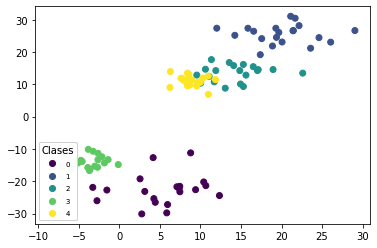

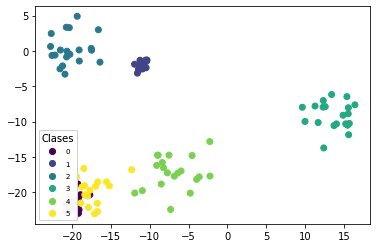

In [5]:
#Prueba de datos: OK!
data1 = generar_datos(5, 2, 20, )
data2 = generar_datos(6, 2, 20, molesto=True)

plot_clusters(data1)
plot_clusters(data2)

In [28]:
def plot_gif(data, y_guess_hist, mu, name='mygif.gif'):
    filenames = []

    for i in range(len(y_guess_hist)):
        plt.scatter(data[:,0], data[:,1], c=y_guess[i]);

        plt.scatter(mu[i][:,0], mu[i][:,1], marker='x', s=100, c='black', linewidths=2)
        # create file name and append it to a list
        filename = f'{i}.png'
        filenames.append(filename)
    
        # save frame
        plt.savefig(filename)
        plt.close()
        
    # build gif

    with imageio.get_writer(name, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)


Algoritmo de k-means

In [25]:
class Kmeans:
    def __init__(self, k, nDim):
        self.k = k
        self.nDim = nDim
        self.y_hist = []
    
    def loadData(self, X):
        self.X = X
        self.m = X.shape[0]
        #Inizializo los mu agarrando k elementos random de X
        self.mu = np.copy(X[np.random.choice(self.m, size=self.k, replace=False)])
        self.mu_hist = []

        
    def assignClusters(self):
        self.y = np.zeros((self.m,))
        self.norm = np.ones((self.k))
        for i in range(self.m):
            for j in range(self.k):
                self.norm[j] = np.linalg.norm(self.X[i,:] - self.mu[j])
            self.y[i] = np.argmin(self.norm)
        self.y_hist.append(self.y)
    
    def updateMeans(self):
        self.mu_hist.append(np.copy(self.mu))
        for i in range(self.k):
            self.mu[i] = np.mean(self.X[self.y==i,:], axis=0)

    def train(self, maxIters):
        for i in range(maxIters):
            self.assignClusters()
            self.updateMeans()

            #Si converge el modelo dejamos de entrenar
            if(np.array_equal(self.mu_hist[-1], self.mu)):
                print("Total iterations: ", i)
                break
            
        
        #Asigno los clusters de los mu finales
        self.assignClusters()
        self.mu_hist.append(np.copy(self.mu))

        return self.y_hist, self.mu_hist


In [27]:
nDim = 2
data = generar_datos(6, nDim, 50, molesto=True)

model = Kmeans(6, nDim)

model.loadData(data[:,:-1])    #No le doy los labels que genera la función generar_datos
y_guess, mu = model.train(50)

Total iterations:  20


In [29]:
plot_gif(data, y_guess, mu, 'mygif.gif')

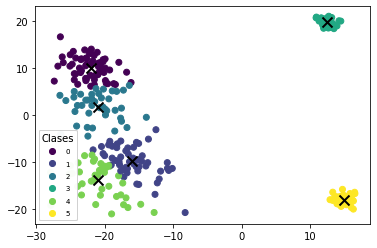

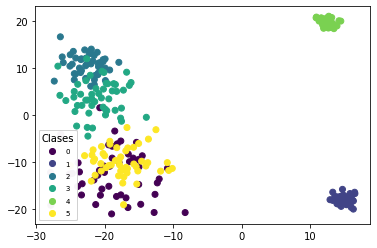

In [30]:
data_guess = np.copy(data)
data_guess[:,-1] = y_guess[-1]
plot_clusters(data_guess, mu=mu[-1])
plot_clusters(data)